In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re as re

# Import Required Libraries for classification 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [3]:
def feature_engineering(train, full_data) :
    
    print("*****************************")
    print("PCLASS VS SURVIVED")
    print("*****************************")
    # PClass
    print(train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())
    
    print("*****************************")
    print("SEX VS SURVIVED")
    print("*****************************")
    #Gender
    print(train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())
    
    for dataset in full_data:
        dataset['Title'] = dataset['Name'].apply(get_title)

    # Name
    # Check title belong to which gender
    print("*****************************")
    print(pd.crosstab(train['Title'], train['Sex']))
    print("*****************************")
    
    # Limit Categorization of data as per gender, from above result
    for dataset in full_data:
        dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
         'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
        dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs') 
    
    print("*****************************")
    print("TITLE VS SURVIVED")
    print("*****************************")
    train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()
    
    # Convert  age in five categorical range and add to dataset as column CategoricalAge
    for dataset in full_data:
        age_avg  = dataset['Age'].mean()
        age_std  = dataset['Age'].std()
        age_null_count = dataset['Age'].isnull().count()
    
        # null is replaced by random nos generated between mean +- stdev
        age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
        dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
        dataset['Age'] = dataset['Age'].astype(int)
    
    train['CategoricalAge'] = pd.cut(train['Age'], 5)
    print("*****************************")
    print("CATEGORICAL AGE VS SURVIVED")
    print("*****************************")
    print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())
    
    print("*****************************")
    print("FAMILY SIZE VS SURVIVED")
    print("*****************************")
    #Family Size 
    for dataset in full_data:
        dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())
    
    print("*****************************")
    print("IS ALONE VS SURVIVED")
    print("*****************************")
    #IsAlone is 1 if FamilySize = 1
    for dataset in full_data:
        dataset['IsAlone'] = 0
        dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())
    
    print("*****************************")
    print("EMBARKED VS SURVIVED")
    print("*****************************")
    #Check Maximum  occurence of Embarked value
    from collections import Counter
    print("Occurence: ",Counter(train['Embarked']))
    # Fill Nan of embarked with S which has maximum occurence in dataset
    for dataset in full_data:
        dataset['Embarked'] = dataset['Embarked'].fillna('S')
    print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())
    
    print("*****************************")
    print("FARE VS SURVIVED")
    print("*****************************")
    # Fare
    # Replace missing values with meadian for Fare
    # Convert into 4 bins
    for dataset in full_data:
        dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    train['CategoricalFare'] = pd.cut(train['Fare'], 4)
    print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())
    
    return train, full_data

In [4]:
def clean_data(train, test, full_data) :
    for dataset in full_data:
        # Mapping Sex
        dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
        # Mapping titles
        title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
        dataset['Title'] = dataset['Title'].map(title_mapping)
        dataset['Title'] = dataset['Title'].fillna(0)
    
        # Mapping Embarked
        dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
        # Mapping Fare
        dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']  = 0
        dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
        dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
        dataset.loc[ dataset['Fare'] > 31, 'Fare']  = 3
        dataset['Fare'] = dataset['Fare'].astype(int)
    
        # Mapping Age
        dataset.loc[ dataset['Age'] <= 16, 'Age']   = 0
        dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
        dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
        dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
        dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4

    # Drop redundant columns
    drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch', 'FamilySize']
    train = train.drop(drop_elements, axis = 1)
    train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

    test  = test.drop(drop_elements, axis = 1)
    print("*****************************")
    print("CLEANED DATA SET")
    print("*****************************")
    print(train.head())
    train = train.values
    test  = test.values
    return train, test, full_data

In [17]:
def classify(x, y) :
    
    # Create array of Classifiers
    classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators = 100, random_state = 0),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]
    
    #Split train data into training set and test set
    from sklearn.model_selection import train_test_split
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)

    acc_dict = {}
    log_cols = ["Classifier", "Accuracy"]
    log  = pd.DataFrame(columns=log_cols)
    
    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(x_train, y_train)
        train_predictions = clf.predict(x_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

    for clf in acc_dict:
        acc_dict[clf] = acc_dict[clf] / 10.0
        log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
        log = log.append(log_entry)

    # Plot accuracy plot    
    plot_accuracy_plot(log)
    return log

In [18]:
def plot_accuracy_plot(log) :
    dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize = dims)

    plt.xlabel('Accuracy')
    plt.title('Classifier Accuracy')

    sns.set_color_codes("muted")
    splot = sns.barplot(ax=ax, x='Accuracy', y='Classifier', data=log, color="b")
    plt.show()

In [19]:
def main() :
    # Import dataset
    train = pd.read_csv('../data/train.csv', header = 0, dtype={'Age': np.float64})
    test  = pd.read_csv('../data/test.csv' , header = 0, dtype={'Age': np.float64})
    full_data = [train, test]
    print("*****************************")
    print("Training dataset Info")
    print("*****************************")
    print (train.info())
    print("*****************************")
    print("Training dataset head")
    print("*****************************")
    print(train.head())
    
    train, full_data = feature_engineering(train, full_data)
    # Clean the data
    train, test, full_data = clean_data(train, test, full_data)
    
    x = train[0::, 1::]
    y = train[0::, 0]

    log = classify(x, y) 
    print(log)

*****************************
Training dataset Info
*****************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
*****************************
Training dataset head
*****************************
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                             

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


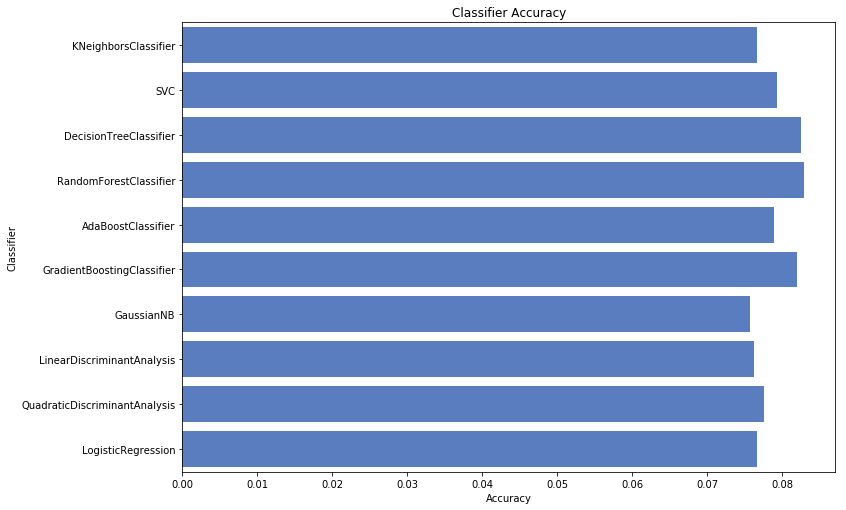

                      Classifier  Accuracy
0           KNeighborsClassifier  0.076682
0                            SVC  0.079372
0         DecisionTreeClassifier  0.082511
0         RandomForestClassifier  0.082960
0             AdaBoostClassifier  0.078924
0     GradientBoostingClassifier  0.082063
0                     GaussianNB  0.075785
0     LinearDiscriminantAnalysis  0.076233
0  QuadraticDiscriminantAnalysis  0.077578
0             LogisticRegression  0.076682


In [20]:
# Invoke main method
main()